In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab


In [2]:
dataDir='/home/kent/git/aiacademy-learning-notebook/Project/ImageCaption/data/coco'
dataType='train2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

print(annFile)
!ls -alh $annFile

/home/kent/git/aiacademy-learning-notebook/Project/ImageCaption/data/coco/annotations/instances_train2014.json
-rw-rw-r-- 1 kent kent 318M Feb 19 09:39 /home/kent/git/aiacademy-learning-notebook/Project/ImageCaption/data/coco/annotations/instances_train2014.json


In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=14.32s)
creating index...
index created!


In [4]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
accessory indoor furniture appliance sports person outdoor electronic animal vehicle kitchen food


In [5]:
coco.dataset['info']

{'contributor': 'COCO Consortium',
 'date_created': '2017/09/01',
 'description': 'COCO 2014 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2014}

In [6]:
coco.dataset.keys()

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses'])

In [7]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


# 載入原始資料

In [8]:
train_set =[]
for img in coco.dataset['images']:
#     print(img)
#     print(img['file_name'])
    
    imgId = img['id']
    
    annIds = coco_caps.getAnnIds(imgIds=imgId)
    anns = coco_caps.loadAnns(annIds)
    
    anns_list = []
    for aann in anns:
#         print(aann['caption'])
        anns_list.append(aann['caption'])
        
    train_set.append((img['file_name'], anns_list))

len(train_set)

82783

# 建立字點表

In [9]:
from pyspark import SparkContext
sc = SparkContext("local", "Simple App")

In [10]:
raw_data = sc.parallelize(train_set)

In [11]:
raw_data.count()

82783

In [16]:
raw_start_end = raw_data.flatMapValues(lambda x : x).mapValues(lambda x : "startstart " + x + " endend")

In [41]:
raw_sq = raw_start_end.mapValues(text_to_word_sequence)

In [42]:
from keras.preprocessing.text import text_to_word_sequence
vocset = set(raw_sq.map(lambda x :x[1]).flatMap(lambda x : x).collect())

In [43]:
len(vocset)

23683

In [44]:
w2index = {}
for index,w in enumerate(vocset):
    w2index[w] = index

In [61]:
index2w = []

for index,w in enumerate(vocset):
    index2w.append(w)

In [49]:
lengths = np.array(raw_sq.mapValues(len).map(lambda x : x[1]).collect())

In [54]:
lengths.mean()

12.467133366979544

(array([1.61584e+05, 2.17281e+05, 3.05650e+04, 3.24900e+03, 9.83000e+02,
        1.90000e+02, 1.35000e+02, 5.60000e+01, 5.60000e+01, 1.40000e+01]),
 array([ 7. , 11.5, 16. , 20.5, 25. , 29.5, 34. , 38.5, 43. , 47.5, 52. ]),
 <a list of 10 Patch objects>)

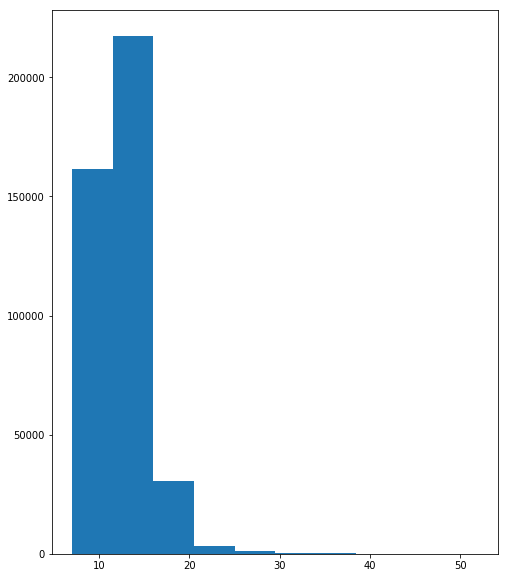

In [57]:
plt.hist(lengths)

In [76]:
from operator import  add
def doMapping(x):
    r = []
    for w in x :
        r.append(w2index[w])
    return r
caption_indexed = raw_sq.mapValues(doMapping).mapValues(lambda x : [x]).reduceByKey(add)

In [77]:
caption_indexed = caption_indexed.collectAsMap()

In [80]:
import pickle
fw = open("caption_indexed.pk","wb")
pickle.dump(caption_indexed,fw)
fw.close()

# 將 Tokenizer 的結果序列化下來

In [83]:
class MyTokenizer:
    caption_indexed = None
    w2index = None
    index2w = None
mytokenizer = MyTokenizer()

mytokenizer.caption_indexed = caption_indexed
mytokenizer.index2w = index2w
mytokenizer.w2index = w2index

fw = open("mytokenizer.pk","wb")
pickle.dump(mytokenizer,fw)
fw.close()


# Word2Vec Model Download

http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/